In [1]:
import pandas as pd
from evds import evdsAPI
import warnings
import pandas as pd
from thefuzz import fuzz
from thefuzz import process
import geopandas as gp
from matplotlib import pyplot as plt
import datetime

C:\ProgramData\Anaconda3\lib\site-packages\thefuzz\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=FutureWarning)

evds=evdsAPI('*********')
a=evds.get_series('bie_hkfe')

a

,SERIE_CODE,SERIE_NAME,START_DATE
0,TP.HKFE01,Konut Fiyat Endeksi (KFE),01-01-2010
1,TP.HKFE02,TR 10 (İstanbul),01-01-2010
2,TP.HKFE03,TR 51 (Ankara),01-01-2010
3,TP.HKFE04,TR 31 (İzmir),01-01-2010
4,TP.HKFE05,"TR 21 (Edirne, Kırklareli, Tekirdağ)",01-01-2010
5,TP.HKFE06,"TR 22 (Balıkesir, Çanakkale)",01-01-2010
6,TP.HKFE07,"TR 32 (Aydın, Denizli, Muğla)",01-01-2010
7,TP.HKFE08,"TR 33 (Afyonkarahisar, Kütahya, Manisa, Uşak)",01-01-2010
8,TP.HKFE09,"TR 41 (Bursa, Eskişehir, Bilecik)",01-01-2010
9,TP.HKFE10,"TR 42 (Bolu, Kocaeli, Sakarya, Yalova, Düzce)",01-01-2010


In [3]:
# Calculate the annual percentage change for Residential Property Price Index index (KFE) data
kfe=evds.get_data(list(a.SERIE_CODE),startdate=a["START_DATE"].unique()[0],enddate=datetime.date.today().strftime("%d-%m-%Y"))
kfe.iloc[:,1:]=kfe.iloc[:,1:].pct_change(12)*100
a["SERIE_CODE"]=a["SERIE_CODE"].str.replace(".","_")

# Prepare data for geospatial mapping
kfe=(pd.melt(kfe, id_vars=["Tarih"], var_name="SERIE_CODE")
    .merge(a[["SERIE_CODE","SERIE_NAME"]], on="SERIE_CODE")
    .assign(Tarih=lambda x: pd.to_datetime(x["Tarih"],infer_datetime_format=True))
    .query('Tarih==Tarih.max()')
    .drop(["SERIE_CODE"],axis=1)
    .query('SERIE_NAME!="Konut Fiyat Endeksi (KFE)"')
    .assign(KOD=lambda x:x["SERIE_NAME"].str.split("(",expand=True)[0])
    .assign(City=lambda x:x["SERIE_NAME"].str.split("(",expand=True)[1])
    .assign(City=lambda x: x["City"].str.replace(")","")))
kfe_il = kfe["City"].str.split(",", expand=True).ffill(axis=1)
kfe = (pd.concat([kfe, kfe_il], axis=1)
       .rename(columns={"value": "value_"})
       .drop(["SERIE_NAME", "Tarih", "KOD"], axis=1))

# Create a dictionary and DataFrame for mapping
il_sozluk = {}
for index, row in kfe.iterrows():
    for i in range(0, 6):
        il_sozluk[row[i]] = row["value_"]
kfe = pd.DataFrame(il_sozluk.items(), columns=['City', "KFE"])
kfe["City"] = kfe["City"].str.strip()
kfe

,City,KFE
0,İstanbul,95.184065
1,Ankara,113.180169
2,İzmir,106.237379
3,Edirne,125.503686
4,Kırklareli,125.503686
...,...,...
76,Şanlıurfa,78.166127
77,Batman,94.368601
78,Mardin,94.368601
79,Siirt,94.368601


In [4]:



turkish_cities_geopoints = (gp.read_file(f'shape_files/TUR_ADM1.shp')
                           .assign(Name=lambda x:x["Name"].str.strip())
                           .assign(Name=lambda x:x["Name"].replace('KIR?EH?R', 'Kırşehir'))
                           .assign(Name=lambda x:x["Name"].replace('A?RI', 'Ağrı'))
                           .assign(City=lambda x:x["Name"].apply(lambda x: process.extractOne(x, kfe["City"], scorer=fuzz.ratio)[0]))
                           .assign(ratio=lambda x:x["Name"].apply(lambda x: process.extractOne(x, kfe["City"], scorer=fuzz.ratio)[1]))
                           .merge(kfe, on ="City")
                           .drop(["City","ratio"],axis=1))

turkish_cities_geopoints



,ISO_Code,Level,Name,adm,adm_int,feature_id,gbid,iso,geometry,KFE
0,TR-01,ADM1,ADANA,ADM1,1,0,TUR_ADM1_1_3_3_0,TUR,"POLYGON ((36.31587 38.36376, 36.31769 38.36367...",118.641317
1,TR-02,ADM1,ADIYAMAN,ADM1,1,1,TUR_ADM1_1_3_3_1,TUR,"POLYGON ((39.25297 38.18188, 39.25334 38.18159...",73.571267
2,TR-03,ADM1,AFYONKARAH?SAR,ADM1,1,2,TUR_ADM1_1_3_3_2,TUR,"POLYGON ((31.14797 39.26246, 31.15825 39.25753...",114.897734
3,TR-04,ADM1,Ağrı,ADM1,1,3,TUR_ADM1_1_3_3_3,TUR,"POLYGON ((43.28706 40.01281, 43.29129 40.00884...",120.828471
4,TR-05,ADM1,AMASYA,ADM1,1,4,TUR_ADM1_1_3_3_4,TUR,"POLYGON ((35.24601 41.02251, 35.25239 41.02232...",108.288076
...,...,...,...,...,...,...,...,...,...,...
76,TR-77,ADM1,YALOVA,ADM1,1,76,TUR_ADM1_1_3_3_76,TUR,"POLYGON ((29.55531 40.68841, 29.55578 40.68816...",113.160595
77,TR-78,ADM1,KARABÜK,ADM1,1,77,TUR_ADM1_1_3_3_77,TUR,"POLYGON ((33.00096 41.56848, 33.00672 41.56848...",134.975369
78,TR-79,ADM1,K?L?S,ADM1,1,78,TUR_ADM1_1_3_3_78,TUR,"POLYGON ((36.98933 37.02075, 36.99112 37.01896...",73.571267
79,TR-80,ADM1,OSMAN?YE,ADM1,1,79,TUR_ADM1_1_3_3_79,TUR,"POLYGON ((36.20403 37.70882, 36.20787 37.70776...",53.177096


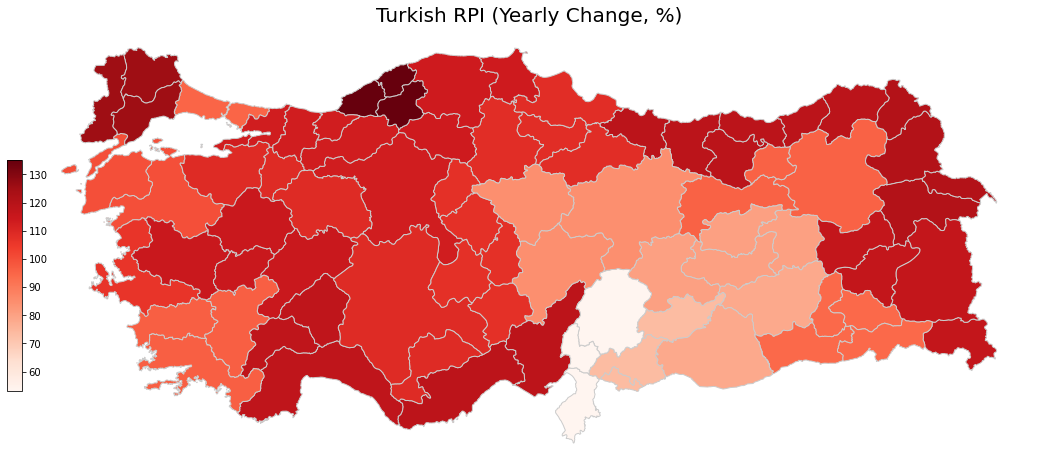

In [5]:
#Graph  phase
title = 'Turkish RPI (Yearly Change, %)'
col="KFE"
vmin = turkish_cities_geopoints[col].min()
vmax = turkish_cities_geopoints[col].max()
cmap = 'Reds'

fig, ax = plt.subplots(1, figsize=(20, 8))
ax.axis('off')
turkish_cities_geopoints.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
ax.set_title(title, fontdict={'fontsize': '20', 'fontweight': '3'})
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.savefig('result_files/residential_price.png')
plt.savefig('result_files/residential_price.pdf')
writer = pd.ExcelWriter('result_files//residential_price.xlsx', engine='xlsxwriter')


In [6]:

# Excel Phase
turkish_cities_geopoints.to_excel(writer, sheet_name='Sheet1')

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Sheet1']
worksheet.insert_image('D3', 'residential_price.png')
writer.save()